# Data analysis for Free Recall wrt. primacy/recency effect, etc.

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kruskal
import ast
import os
import re
import scikit_posthocs as sp

### Loading Data 

(important: make sure to be able to do it for every computer by using the package "os")

In [113]:
# Load the data
filepath = os.getcwd() # Get the current working directory to analysis

results_filepath = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','free_recall_results.csv'))

print(f"{filepath}\n{results_filepath}")

df = pd.read_csv(results_filepath)

c:\Users\Oliver\OneDrive\Dokumenter\GitHub\AI-HC-Project1\analysis
c:\Users\Oliver\OneDrive\Dokumenter\GitHub\AI-HC-Project1\Experiment_Output\free_recall_results.csv


### Cleaning Data

In [114]:
# --- Improved cleaning function ---
def clean_word_list(val):
    """Convert messy string/list representations into a flat list of clean, lowercase words."""
    if pd.isna(val):
        return []

    try:
        # Safely parse Python literal
        parsed = ast.literal_eval(val)
    except (ValueError, SyntaxError):
        parsed = str(val)

    # Flatten and clean
    flat_list = []
    if isinstance(parsed, list):
        for item in parsed:
            # If item is a list, flatten
            if isinstance(item, list):
                for sub in item:
                    # Remove brackets, commas, extra spaces
                    w = re.sub(r"[\[\],]", "", str(sub)).strip().lower()
                    if w:
                        flat_list.append(w)
            else:
                # Remove brackets, commas, extra spaces
                w = re.sub(r"[\[\],]", "", str(item)).strip().lower()
                if w:
                    # split by spaces if there are multiple words
                    flat_list.extend([word for word in w.split() if word])
    else:
        w = re.sub(r"[\[\],]", "", str(parsed)).strip().lower()
        flat_list.extend([word for word in w.split() if word])

    return flat_list

# --- Load raw file ---
df_test = pd.read_csv(results_filepath)

# --- Clean column names ---
df_test.columns = df_test.columns.str.strip()

# --- Apply cleaning ---
df_test['presented_words'] = df_test['presented_words'].apply(clean_word_list)
df_test['recalled_words']  = df_test['recalled_words'].apply(clean_word_list)

# --- Update trial ID and sort by condition ---
df_test['trial'] = df_test['trial'].astype(int)
df_test = df_test.sort_values(by=['condition', 'trial']).reset_index(drop=True)
df_test['trial'] = df_test.groupby('condition').cumcount() + 1

# --- Save cleaned CSV ---
cleaned_filepath = os.path.abspath(os.path.join(filepath,'..','Experiment_Output','free_recall_results_cleaned.csv'))
df_test.to_csv(cleaned_filepath, index=False)

print(f"✅ Cleaned data saved to {cleaned_filepath}")

# --- Example check ---
# print(df_test.head())
# print(type(df_test['recalled_words'][0]), type(df_test['presented_words'][0]))


✅ Cleaned data saved to c:\Users\Oliver\OneDrive\Dokumenter\GitHub\AI-HC-Project1\Experiment_Output\free_recall_results_cleaned.csv


### Calculate Metrics (accuracy, primacy/recency,...)

In [115]:
def calculate_metrics(presented, recalled):
    """Calculate primacy, recency and accuracy for 15-word lists"""
    # Check length & empty recall
    if len(presented) != 15 or not recalled:
        return {'primacy': 0, 'recency': 0, 'accuracy': 0}
    
    # Clean both lists
    presented_clean = [word.strip().lower() for word in presented]
    recalled_clean = [word.strip().lower() for word in recalled]
    
    # Accuracy: proportion of recalled words that were in presented list
    correct_recalls = sum(1 for word in recalled_clean if word in presented_clean)
    accuracy = correct_recalls / len(presented_clean)
    
    # Primacy: first 5 words
    primacy_words = presented_clean[:5]
    primacy_recalled = sum(1 for word in recalled_clean if word in primacy_words)
    primacy = primacy_recalled / 5
    
    # Recency: last 5 words
    recency_words = presented_clean[-5:]
    recency_recalled = sum(1 for word in recalled_clean if word in recency_words)
    recency = recency_recalled / 5
    
    return {
        'primacy': primacy,
        'recency': recency,
        'accuracy': accuracy
    }

# --- Apply to dataframe ---
results = []
for _, row in df_test.iterrows():
    metrics = calculate_metrics(row['presented_words'], row['recalled_words'])
    metrics['trial'] = row['trial']
    metrics['condition'] = row['condition']
    results.append(metrics)

results_df = pd.DataFrame(results)
print(f"{results_df.describe()}")

# Summary statistics
print("\nFree Recall Analysis - Summary Statistics:")
print(f"Average Accuracy across conditions: {results_df['accuracy'].mean():.3f}")
print(f"Average Primacy across conditions: {results_df['primacy'].mean():.3f}")
print(f"Average Recency across conditions: {results_df['recency'].mean():.3f}")
print(f"Primacy vs Recency difference: {abs(results_df['recency'].mean() - results_df['primacy'].mean()):.3f}")


          primacy     recency    accuracy       trial
count  321.000000  321.000000  321.000000  321.000000
mean     0.524611    0.459813    0.444860   40.626168
std      0.267719    0.262985    0.142529   23.202582
min      0.000000    0.000000    0.133333    1.000000
25%      0.400000    0.200000    0.333333   21.000000
50%      0.600000    0.400000    0.400000   41.000000
75%      0.800000    0.600000    0.533333   61.000000
max      1.000000    1.000000    0.933333   81.000000

Free Recall Analysis - Summary Statistics:
Average Accuracy across conditions: 0.445
Average Primacy across conditions: 0.525
Average Recency across conditions: 0.460
Primacy vs Recency difference: 0.065


### Get graphs/data for each condition

In [116]:
# --- Per-trial metrics ---
# print("🔹 First 10 trials:")
# print(results_df.head(10))

# --- Averages by condition ---
condition_metrics = (results_df.groupby('condition')[['primacy','recency','accuracy']].mean())

print("\nAverages by condition:")
print(condition_metrics)

# --- Optional: export condition-level summary ---
summary = condition_metrics.to_dict(orient='index')



Averages by condition:
           primacy   recency  accuracy
condition                             
break      0.53250  0.422500  0.460833
fast       0.45250  0.407500  0.353333
math       0.54000  0.520000  0.507500
normal     0.57284  0.488889  0.457613


### Function for Serial Position Curve (SPC)

In [117]:
# --- Serial Position Curve Analysis (overall + per condition) ---
def serial_position_analysis(df_test):
    conditions = df_test['condition'].unique()
    
    # initialize counters
    overall = {"position_recalls": [0] * 15, "position_totals": [0] * 15}
    per_condition = {
        cond: {"position_recalls": [0] * 15, "position_totals": [0] * 15}
        for cond in conditions
    }

    # loop through rows
    for _, row in df_test.iterrows():
        presented = row['presented_words']
        recalled = row['recalled_words']
        cond = row['condition']

        if len(presented) != 15 or not recalled:
            continue

        presented_clean = [w.strip().lower() for w in presented]
        recalled_clean = [w.strip().lower() for w in recalled if w and w.strip()]

        for pos in range(15):
            # update overall
            overall["position_totals"][pos] += 1
            if presented_clean[pos] in recalled_clean:
                overall["position_recalls"][pos] += 1

            # update condition-specific
            per_condition[cond]["position_totals"][pos] += 1
            if presented_clean[pos] in recalled_clean:
                per_condition[cond]["position_recalls"][pos] += 1

    # compute recall probabilities
    def compute_probs(stats):
        return [
            r / t if t > 0 else 0
            for r, t in zip(stats["position_recalls"], stats["position_totals"])
        ]

    recall_probs = {
        "overall": compute_probs(overall),
        "per_condition": {cond: compute_probs(stats) for cond, stats in per_condition.items()}
    }

    return recall_probs


### Print recall probs (probabilities) per-condition

In [118]:
serial_curves = serial_position_analysis(df_test)

# Overall curve (all conditions pooled)
overall_curve = [round(x, 3) for x in serial_curves["overall"]]

# Condition-specific curves
condition_curves = {cond: [round(x, 3) for x in curve] 
                    for cond, curve in serial_curves["per_condition"].items()}

print("Overall recall probs:")
print(overall_curve)

print("\nPer condition recall probs:")
for cond, curve in condition_curves.items():
    print(f"{cond} (80 trials): {curve}")


Overall recall probs:
[0.726, 0.57, 0.449, 0.47, 0.386, 0.355, 0.355, 0.352, 0.368, 0.312, 0.33, 0.386, 0.439, 0.502, 0.614]

Per condition recall probs:
break (80 trials): [0.613, 0.6, 0.5, 0.487, 0.45, 0.45, 0.412, 0.45, 0.45, 0.375, 0.362, 0.375, 0.412, 0.388, 0.575]
fast (80 trials): [0.775, 0.512, 0.412, 0.325, 0.212, 0.237, 0.212, 0.15, 0.2, 0.175, 0.212, 0.35, 0.388, 0.487, 0.6]
math (80 trials): [0.625, 0.537, 0.438, 0.6, 0.487, 0.463, 0.45, 0.5, 0.487, 0.412, 0.463, 0.562, 0.5, 0.525, 0.525]
normal (80 trials): [0.889, 0.63, 0.444, 0.469, 0.395, 0.272, 0.346, 0.309, 0.333, 0.284, 0.284, 0.259, 0.457, 0.605, 0.753]


### Compute Analytical factors

CI (95%), Kruskal-Wallis test (non-parametric alternative to one-way ANOVA) and Dunn’s post-hoc test for each condition

In [119]:
def compute_ci(data, confidence=0.95):
    """Return mean and 95% confidence interval."""
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)  # standard error of the mean
    h = sem * stats.t.ppf((1 + confidence) / 2., n-1)  # margin
    return mean, mean-h, mean+h

# Compute CI per condition
ci_results = {}
conditions = results_df['condition'].unique()

for cond in conditions:
    subset = results_df[results_df['condition'] == cond]['accuracy']
    mean, lower, upper = compute_ci(subset)
    ci_results[cond] = {'mean': mean, 'ci_lower': lower, 'ci_upper': upper}

print("Accuracy with 95% CI per condition:")
for cond, vals in ci_results.items():
    print(f"{cond}: mean={vals['mean']:.3f}, 95% CI=({vals['ci_lower']:.3f}, {vals['ci_upper']:.3f})")


# Ensure numeric accuracy
results_df['accuracy'] = pd.to_numeric(results_df['accuracy'], errors='coerce')

# Drop NaN accuracy rows
results_clean = results_df.dropna(subset=['accuracy'])

# Check number of trials per condition
# print(results_clean.groupby('condition')['accuracy'].count())

# --- Kruskal-Wallis test across all conditions ---
fast_acc    = results_clean[results_clean['condition']=='fast']['accuracy']
normal_acc      = results_clean[results_clean['condition']=='normal']['accuracy']
break_acc = results_clean[results_clean['condition']=='break']['accuracy']
math_acc     = results_clean[results_clean['condition']=='math']['accuracy']

h_stat, p_val = kruskal(fast_acc, normal_acc, break_acc, math_acc)
print(f"\nKruskal-Wallis test: H={h_stat:.3f}, p={p_val:.3e}")
if p_val < 0.05:
    print("Significant differences between conditions (p < 0.05)")
else:
    print("No significant differences between conditions (p >= 0.05)")

# --- Pairwise comparisons with Dunn's test (Bonferroni correction) ---

# Install scikit-posthocs if not already installed
# !pip install scikit-posthocs


# Ensure accuracy is numeric and drop NaNs
results_clean = results_df.copy()
results_clean['accuracy'] = pd.to_numeric(results_clean['accuracy'], errors='coerce')
results_clean = results_clean.dropna(subset=['accuracy'])

# Run Dunn's test with Bonferroni correction
dunn_results = sp.posthoc_dunn(
    results_clean, 
    val_col='accuracy', 
    group_col='condition', 
    p_adjust='bonferroni'
)

print(f"\nPairwise Dunn's test (Bonferroni corrected p-values):")
print(dunn_results)

# Determine significance
alpha = 0.05
conditions = dunn_results.columns.tolist()

print("\nSignificance summary:")
for i, cond1 in enumerate(conditions):
    for j, cond2 in enumerate(conditions):
        if j <= i:
            continue  # avoid duplicates and self-comparison
        p_val = dunn_results.loc[cond1, cond2]
        if p_val < alpha:
            print(f"- {cond1} vs {cond2}: SIGNIFICANT difference (p={p_val:.3e})")
        else:
            print(f"- {cond1} vs {cond2}: NOT significantly different (p={p_val:.3e})")



Accuracy with 95% CI per condition:
break: mean=0.461, 95% CI=(0.434, 0.487)
fast: mean=0.353, 95% CI=(0.335, 0.372)
math: mean=0.508, 95% CI=(0.472, 0.543)
normal: mean=0.458, 95% CI=(0.424, 0.491)

Kruskal-Wallis test: H=58.224, p=1.408e-12
Significant differences between conditions (p < 0.05)

Pairwise Dunn's test (Bonferroni corrected p-values):
               break          fast          math    normal
break   1.000000e+00  4.841360e-08  9.528529e-01  1.000000
fast    4.841360e-08  1.000000e+00  4.303652e-12  0.000008
math    9.528529e-01  4.303652e-12  1.000000e+00  0.110555
normal  1.000000e+00  7.735476e-06  1.105549e-01  1.000000

Significance summary:
- break vs fast: SIGNIFICANT difference (p=4.841e-08)
- break vs math: NOT significantly different (p=9.529e-01)
- break vs normal: NOT significantly different (p=1.000e+00)
- fast vs math: SIGNIFICANT difference (p=4.304e-12)
- fast vs normal: SIGNIFICANT difference (p=7.735e-06)
- math vs normal: NOT significantly different (p

### Ultimate Plot (SPC, primacy vs recency, accuracy)

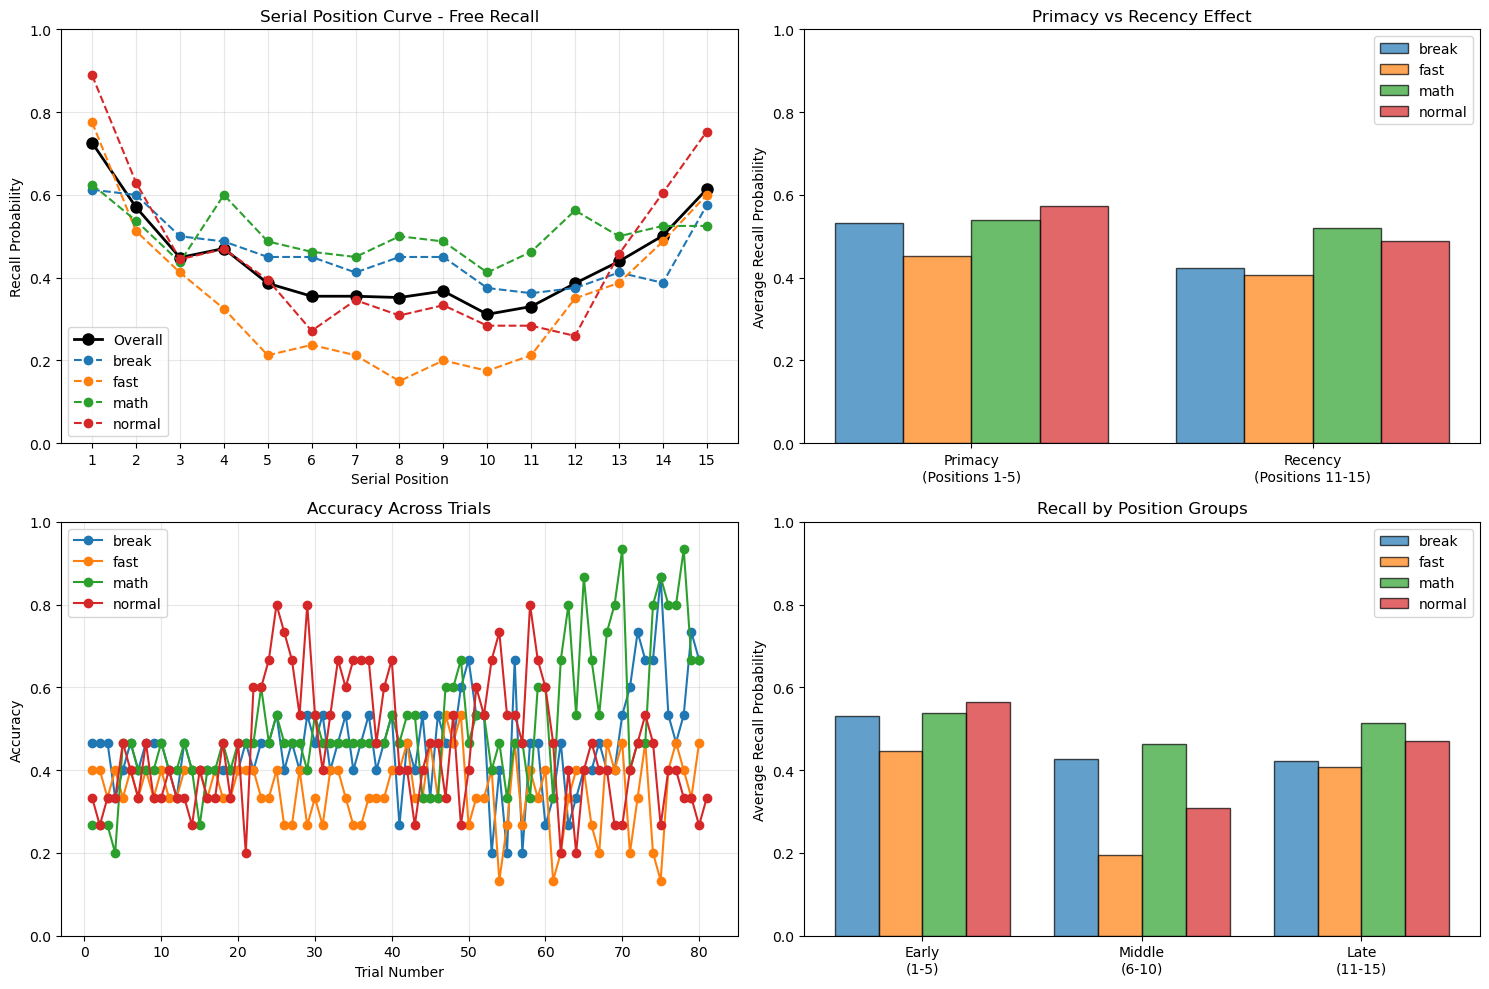

In [120]:
# --- Get serial position data (overall + per condition) ---
recall_probs_dict = serial_position_analysis(df_test)  # returns {'overall': [...], 'per_condition': {...}}
positions = list(range(1, 16))
conditions = list(recall_probs_dict['per_condition'].keys())

# --- Create plots ---
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Serial Position Curve (Overall + per condition)
ax1.plot(positions, recall_probs_dict['overall'], 'ko-', linewidth=2, markersize=8, label='Overall')
for cond in conditions:
    ax1.plot(positions, recall_probs_dict['per_condition'][cond], marker='o', linestyle='--', label=cond)
ax1.set_xlabel('Serial Position')
ax1.set_ylabel('Recall Probability')
ax1.set_title('Serial Position Curve - Free Recall')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)
ax1.set_xticks(range(1, 16))
ax1.legend()

# 2. Primacy vs Recency (per condition)
categories = ['Primacy\n(Positions 1-5)', 'Recency\n(Positions 11-15)']
bar_width = 0.2
x = np.arange(len(categories))

for i, cond in enumerate(conditions):
    values = [results_df[results_df['condition']==cond]['primacy'].mean(),
              results_df[results_df['condition']==cond]['recency'].mean()]
    ax2.bar(x + i*bar_width, values, width=bar_width, alpha=0.7, edgecolor='black', label=cond)
ax2.set_xticks(x + bar_width*(len(conditions)-1)/2)
ax2.set_xticklabels(categories)
ax2.set_ylabel('Average Recall Probability')
ax2.set_title('Primacy vs Recency Effect')
ax2.set_ylim(0, 1)
ax2.legend()

# 3. Accuracy by Trial (per condition)
for cond in conditions:
    subset = results_df[results_df['condition']==cond]
    ax3.plot(subset['trial'], subset['accuracy'], marker='o', linestyle='-', markersize=6, label=cond)
ax3.set_xlabel('Trial Number')
ax3.set_ylabel('Accuracy')
ax3.set_title('Accuracy Across Trials')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1)
ax3.legend()

# 4. Position Groups (Overall + per condition)
positions_grouped = ['Early\n(1-5)', 'Middle\n(6-10)', 'Late\n(11-15)']
bar_width = 0.2
x = np.arange(len(positions_grouped))

for i, cond in enumerate(conditions):
    curve = recall_probs_dict['per_condition'][cond]
    values_grouped = [np.mean(curve[:5]), np.mean(curve[5:10]), np.mean(curve[10:15])]
    ax4.bar(x + i*bar_width, values_grouped, width=bar_width, alpha=0.7, edgecolor='black', label=cond)

ax4.set_xticks(x + bar_width*(len(conditions)-1)/2)
ax4.set_xticklabels(positions_grouped)
ax4.set_ylabel('Average Recall Probability')
ax4.set_title('Recall by Position Groups')
ax4.set_ylim(0, 1)
ax4.legend()

plt.tight_layout()
plt.show()
